<a href="https://colab.research.google.com/github/Splav12341/Article-Semi-Supervised_GAN/blob/main/article.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


SGAN Implementation
==============

Credit to  `Augustus Odena <https://arxiv.org/abs/1606.01583>` for the original paper this is based on.




In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# from __future__ import print_function
#%matplotlib inline
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import Image

import time

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
# Create directory to store images from Generator after each epoch
# to keep track of Generator performance
directory = "imagesMNIST"
if not os.path.exists(directory):
  os.makedirs(directory)

In [3]:
ls -l

total 8
drwxr-xr-x 2 root root 4096 May 24 15:44 imagesMNIST/
drwxr-xr-x 1 root root 4096 May 17 13:39 sample_data/


In [4]:
# Root directory for dataset
dataroot = '/content'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 25

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Number of channels in the training images. For color images this is 3
nc = 1

num_classes = 10

In [5]:
# Create directory MNNIST, download and store MNIST data from pytorch to it

trans = transforms.Compose([transforms.Resize(image_size),
                            transforms.CenterCrop(image_size),
                            transforms.ToTensor(), 
                            transforms.Normalize([0.5], [0.5])])

train_set = dset.MNIST(root='./', train=True, transform=trans,
                       download = True)

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## weights initialization

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.Linear1 = nn.Linear(nz, 128 * 7 * 7)
        self.leaky_relu = nn.LeakyReLU(0.2)

        self.convT1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=4,
                                     stride=2, padding=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(128)
        self.leaky_relu1 = nn.LeakyReLU(0.2)
###########################################
        self.convT2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=4,
                                     stride=2, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.leaky_relu2 = nn.LeakyReLU(0.2)
###########################################
        self.convT3 = nn.ConvTranspose2d(in_channels=128, out_channels=nc, kernel_size=1,
                                     stride=1, padding=0, bias=False)

    def forward(self, input):
        out = self.Linear1(input.squeeze())
        out = self.leaky_relu(out)
        out = out.reshape(-1,128,7,7)

        out = self.convT1(out)
        out = self.batchnorm1(out)
        out = self.leaky_relu1(out)

        out = self.convT2(out)
        out = self.batchnorm2(out)
        out = self.leaky_relu2(out)

        out = self.convT3(out)

        return torch.tanh(out)

# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake = netG(noise)
print(fake.shape)

torch.Size([25, 1, 28, 28])


## Discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(in_channels=nc, out_channels=128,
                           kernel_size=3, stride=2,
                           padding=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(128)
        self.leaky_relu1 = nn.LeakyReLU(0.2)
##########################################
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128,
                           kernel_size=3, stride=2,
                           padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.leaky_relu2 = nn.LeakyReLU(0.2)
#########################################
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128,
                           kernel_size=3, stride=2,
                           padding=1, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.leaky_relu3 = nn.LeakyReLU(0.2)
#########################################
        self.Linear = nn.Linear(128*4*4, self.num_classes)


    def forward(self, input):

        out = self.conv1(input)
        out = self.batchnorm1(out)
        out = self.leaky_relu1(out)
        #############################
        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.leaky_relu2(out)
        #############################
        out = self.conv3(out)
        out = self.batchnorm3(out)
        out = self.leaky_relu3(out)
        #############################
        out = out.view(-1,128*4*4)
        out = self.Linear(out)
        xe = torch.exp(out)
        logexpsum = xe.sum(dim = -1)
        adv = logexpsum / (logexpsum + 1) # real_fake
        aux = F.softmax(out.squeeze(), dim = 1) # classification

        return adv, aux

# Create the Discriminator
num_classes = 10
netD = Discriminator(num_classes).to(device)
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

noise = torch.randn(batch_size, 1, 28, 28, device=device)
adv, aux = netD(noise)
print(aux.shape)

torch.Size([25, 10])


In [9]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [10]:
# select a supervised subset of the dataset, ensures classes are balanced
from numpy.random import randint
# np.random.seed(0)

def select_supervised_samples(data=train_set.data, labels=train_set.targets, n_samples=100, n_classes=10):
    X, y = data, labels
    X_list, y_list = list(), list()
    n_per_class = int(n_samples / n_classes)
    for i in range(n_classes):
        # get all images for this class
        X_with_class = X[y == i]
        # choose random instances
        np.random.seed(0)
        ix = randint(0, len(X_with_class), n_per_class)
        # add to list
        [X_list.append(X_with_class[j]) for j in ix]
        [y_list.append(i) for j in ix]

    return X_list, y_list



def get_supervised_samples():
    X_list, y_list = select_supervised_samples()
    y = torch.tensor(y_list)
    X = X_list[0][None, None, :]
    for i in range(1, len(X_list)):
        X = torch.cat((X, X_list[i][None, None, :]), axis=0)
        
#     return X.to(device), y.to(device)

    x_tmp = X.view(-1, 28**2)
    x_tmp.shape
    noise = torch.randn(x_tmp.size())
    x_tmp = (x_tmp + noise).view(X.size())

    return x_tmp.to(device), y.to(device)

In [11]:
def train_netD(real_data, labels, optimizerD):
    optimizerD.zero_grad()
    
    supervised_batch = batch_size // 2
    bce_loss = nn.BCELoss()
    ce_loss = nn.CrossEntropyLoss()

    # update supervised discriminator
    # idxs = np.random.randint(0, real_data.shape[0], supervised_batch)
    # supervised_real, supervised_targets = real_data[idxs], labels[idxs]
    supervised_real, supervised_targets = get_supervised_samples()


    # print(supervised_real.shape, supervised_targets.shape) # torch.Size([12, 1, 28, 28]) torch.Size([12])
    _, classific_label = netD(supervised_real)
    classific_real_loss = ce_loss(classific_label, supervised_targets.to(device))

    # update unsupervised discriminator (adv)
    real_fake, _ = netD(real_data)
    real_targets = torch.ones(real_data.shape[0], dtype=torch.float32).to(device)
    real_fake_loss = bce_loss(real_fake, real_targets)

    noise = torch.randn(real_data.shape[0], nz, 1, 1, device=device)
    fake = netG(noise)
    fake_real, _ = netD(fake.detach())
    fake_real_loss = bce_loss(fake_real.view(-1), fake_targets)

    # loss
    lossD = 0.5 * (real_fake_loss + fake_real_loss) + classific_real_loss
    lossD.backward()
    # Update D
    optimizerD.step()

    # Calculate discriminator accuracy

    pred = np.concatenate([classific_label.data.cpu().numpy(),
                              ], axis=0)
    gt = np.concatenate([supervised_targets.data.cpu().numpy(),
                            ], axis=0)
    d_acc = np.mean(np.argmax(pred, axis=1) == gt)

    with torch.no_grad():
        idxs = np.random.randint(0, real_data.shape[0], supervised_batch)
        supervised_real, supervised_targets = real_data[idxs], labels[idxs]
        _, classific_label = netD(supervised_real)

        pred = np.concatenate([classific_label.data.cpu().numpy(),
                                ], axis=0)
        gt = np.concatenate([supervised_targets.data.cpu().numpy(),
                                ], axis=0)
        d_acc_test = np.mean(np.argmax(pred, axis=1) == gt)

#     d_acc_test = 0
    return lossD.item(), d_acc, d_acc_test

In [12]:
def train_netG(real_targets, optimizerG):
    optimizerG.zero_grad()

    bce_loss = nn.BCELoss()

    # update generator (g)
    noise = torch.randn(real_data.shape[0], nz, 1, 1, device=device)
    fake = netG(noise)
    adv_g, _ = netD(fake)
    lossG = bce_loss(adv_g.view(-1), real_targets)
    lossG.backward()

    # Update G
    optimizerG.step()

    return lossG.item()

In [13]:
from IPython.display import clear_output
import torchvision.transforms as T
# Lists to keep track of progress
img_list = []
img_list_fixedN = []
G_losses = []
D_losses = []
iters = 0

train_accuracy = []
test_accuracy = []

sample_interval = 100
num_epochs = 5
len_train_loader = len(train_loader)

supervised_batch = batch_size // 2

netD.train(True)
netG.train(True)
t0 = time.time()
print("Starting Training Loop...")

for epoch in range(num_epochs):
    ep_train_accuracy = []
    ep_test_accuracy = []
    for i, (imgs, labels) in enumerate(train_loader):
#         clear_output(True)
        real_data = imgs.to(device)

        real_targets = torch.ones(real_data.shape[0], dtype=torch.float32).to(device)
        fake_targets = torch.zeros(real_data.shape[0], dtype=torch.float32).to(device)
        
        lossD, d_acc, d_acc_test = train_netD(real_data, labels, optimizerD)

        lossG = train_netG(real_targets, optimizerG)

        G_losses.append(lossG)
        D_losses.append(lossD)
        train_accuracy.append(d_acc)
        test_accuracy.append(d_acc_test)
        
        ep_train_accuracy.append(d_acc)
        ep_test_accuracy.append(d_acc_test)
        
#         if iters % 1000 < 10:
#             fig, axs = plt.subplots(2, 3, figsize=(20,12))

#             axs[0, 0].plot(G_losses[:], label=f'ep_gen={epoch}', color='green')
#             axs[0, 0].plot(D_losses[:], label=f'ep_discr={epoch}', color='blue')
#             axs[0, 0].legend()
#             axs[0, 0].grid()

#             axs[0, 1].plot(train_accuracy[:], label=f'ep_acc={epoch}', color='black')
#             axs[0, 1].legend()
#             axs[0, 1].grid()

#             axs[0, 2].plot(test_accuracy[:], label=f'ep_acc={epoch}', color='black')
#             axs[0, 2].legend()
#             axs[0, 2].grid()

#             noise = torch.randn(real_data.shape[0], nz, 1, 1, device=device)
#             fake_img = netG(noise)

#             for k in range(10):
#                 img = T.ToPILImage()(fake_img[k])
#                 axs[1, k%3].imshow(img)
#             plt.show()

        iters += 1
    print(f'epoch ={epoch}/{num_epochs}')
    time.time() - t0
    print(f'spent_time ={time.time() - t0}')
    print('ep_train_accuracy', np.mean(ep_train_accuracy))
    print('ep_test_accuracy', np.mean(ep_test_accuracy))
    print('----------------------')

Starting Training Loop...
epoch =0/5
spent_time =285.8112494945526
ep_train_accuracy 0.9980125
ep_test_accuracy 0.9008333333333334
----------------------
epoch =1/5
spent_time =568.5004501342773
ep_train_accuracy 1.0
ep_test_accuracy 0.9367013888888888
----------------------
epoch =2/5
spent_time =849.0491442680359
ep_train_accuracy 1.0
ep_test_accuracy 0.946111111111111
----------------------
epoch =3/5
spent_time =1128.6585936546326
ep_train_accuracy 1.0
ep_test_accuracy 0.9469791666666667
----------------------
epoch =4/5
spent_time =1408.1920807361603
ep_train_accuracy 1.0
ep_test_accuracy 0.946736111111111
----------------------


# Losses, metrics and generated examples

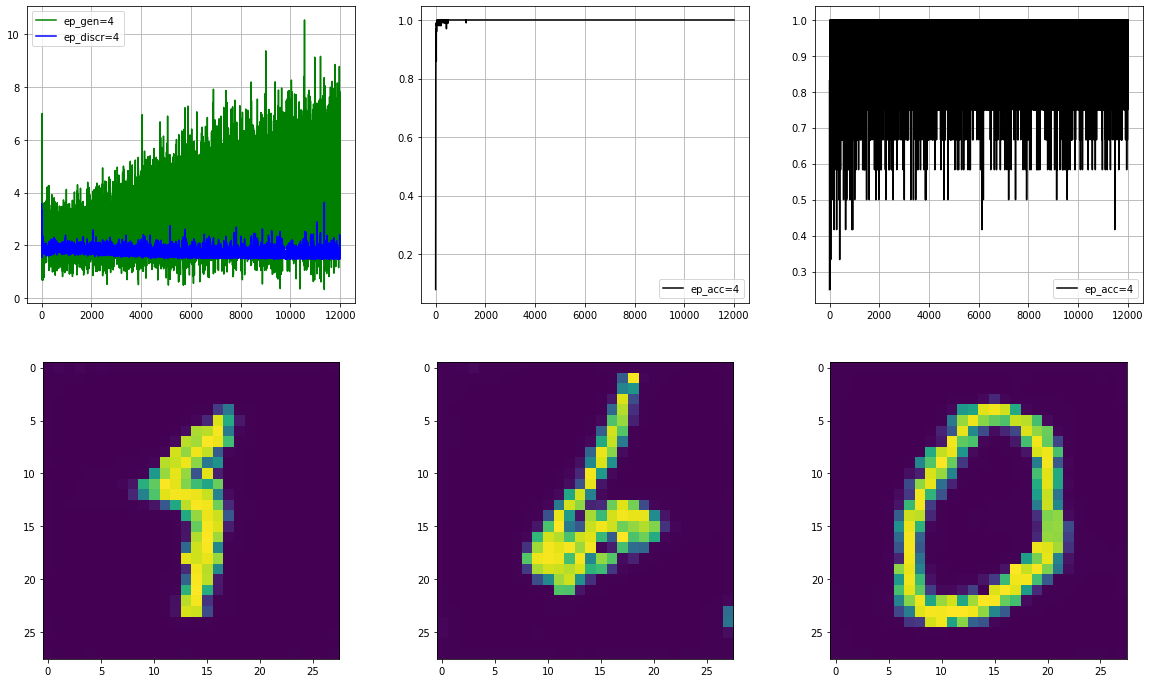

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(20,12))

axs[0, 0].plot(G_losses[:], label=f'ep_gen={epoch}', color='green')
axs[0, 0].plot(D_losses[:], label=f'ep_discr={epoch}', color='blue')
axs[0, 0].legend()
axs[0, 0].grid()

axs[0, 1].plot(train_accuracy[:], label=f'ep_acc={epoch}', color='black')
axs[0, 1].legend()
axs[0, 1].grid()

axs[0, 2].plot(test_accuracy[:], label=f'ep_acc={epoch}', color='black')
axs[0, 2].legend()
axs[0, 2].grid()


imgs, labels = next(iter(train_loader))
real_data = imgs.to(device)
    
noise = torch.randn(real_data.shape[0], nz, 1, 1, device=device)
fake_img = netG(noise)

for k in range(10):
    img = T.ToPILImage()(fake_img[k])
    axs[1, k%3].imshow(img)
plt.show()

# Check model on test dataset

In [15]:
import torchvision

def MnistTested():
    return torchvision.datasets.MNIST('../data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))

In [16]:
tested = MnistTested()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [17]:
trans = transforms.Compose([transforms.Resize(image_size),
                            transforms.CenterCrop(image_size),
                            transforms.ToTensor(), 
                            transforms.Normalize([0.5], [0.5])])

test_set = dset.MNIST(root='../data', train=False, transform=trans)
# test_set = MnistTested()

test_loader = torch.utils.data.DataLoader(
                 dataset=test_set,
                 batch_size=25,
                 shuffle=True)

In [18]:
netD.train()
test_loss = 0
correct = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        adv, aux = netD(imgs.to(device))
        test_loss += F.nll_loss(aux, labels.to(device), size_average=False).item()
        pred = aux.data.max(1, keepdim=True)[1]
        correct += pred.eq(labels.to(device).data.view_as(pred)).sum()

test_loss /= len(test_loader.dataset)
# test_loss.append(test_loss)
  
print(f'Avg. loss: {test_loss}, Accuracy: {correct}/{len(test_loader.dataset)} {100. * correct / len(test_loader.dataset)}')

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Avg. loss: -0.9459525938034058, Accuracy: 9598/10000 95.97999572753906


# Plot examples

torch.Size([25, 1, 28, 28])


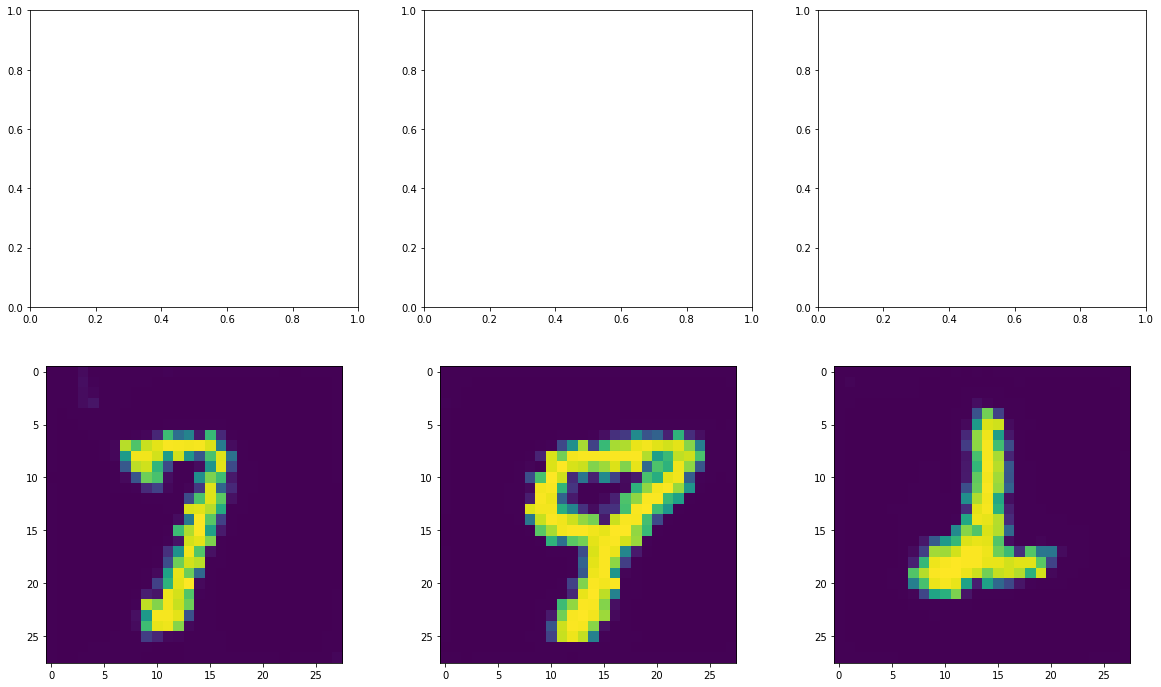

In [19]:
import torchvision.transforms as T

noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake = netG(noise)
print (fake.shape)

fig, axs = plt.subplots(2, 3, figsize=(20,12))

for k in range(10):
    img = T.ToPILImage()(fake[k])
    axs[1, k%3].imshow(img)

plt.show()